In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Ensure the correct backend is used
%matplotlib inline

Check out the Jupyter notebooks for Chapter 9 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part01_image-segmentation.ipynb, https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part02_modern-convnet-architecture-patterns.ipynb, and https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_part03_interpreting-what-convnets-learn.ipynb. Then:

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import array_to_img

2024-07-21 09:11:48.725193: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
path_to_dataset = "/scratch/user/cpepis/CSCE636/"
PATH = os.path.join(os.path.dirname(path_to_dataset), "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, "train")
test_dir = os.path.join(PATH, "validation")

batch_size = 32
image_size = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=batch_size, image_size=image_size
)

test_datset = tf.keras.utils.image_dataset_from_directory(
    test_dir, shuffle=True, batch_size=batch_size, image_size=image_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2024-07-21 09:11:56.204960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22958 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [5]:
val_batches = tf.data.experimental.cardinality(test_datset)
testing_dataset = test_datset.take(val_batches // 5)
validation_dataset = test_datset.skip(val_batches // 5)

In [6]:
for data_batch, label_batch in train_dataset:
    print("Data Batch Shape is ", data_batch.shape)
    print("Label Batch Shape is ", label_batch.shape)
    break

Data Batch Shape is  (32, 150, 150, 3)
Label Batch Shape is  (32,)


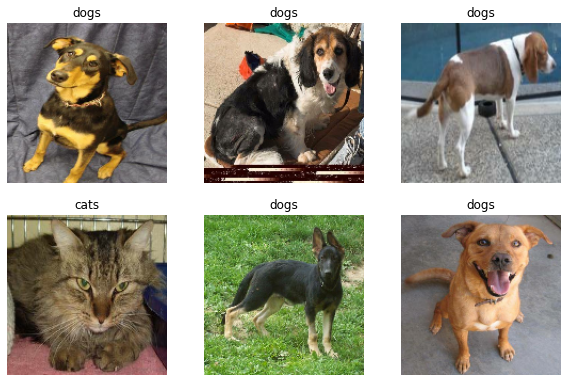

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis("off")
    break

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.1),
    ]
)

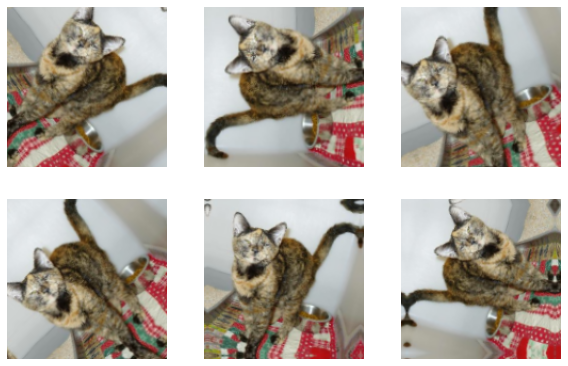

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
    break

In [10]:
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset, epochs=50, validation_data=validation_dataset, callbacks=callbacks
)

Epoch 1/50


2024-07-21 09:12:18.174837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2024-07-21 09:12:19.505516: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2ac53c026ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-21 09:12:19.505590: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2024-07-21 09:12:19.515183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 09:12:19.685318: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 17s 115ms/step - loss: 0.7277 - accuracy: 0.5185 - val_loss: 0.8092 - val_accuracy: 0.5161
Epoch 2/50
63/63 [==============================] - 7s 104ms/step - loss: 0.6957 - accuracy: 0.5075 - val_loss: 0.6895 - val_accuracy: 0.5050
Epoch 3/50
63/63 [==============================] - 7s 104ms/step - loss: 0.6940 - accuracy: 0.5590 - val_loss: 0.6771 - val_accuracy: 0.6114
Epoch 4/50
63/63 [==============================] - 7s 105ms/step - loss: 0.6813 - accuracy: 0.5860 - val_loss: 0.6444 - val_accuracy: 0.6423
Epoch 5/50
63/63 [==============================] - 7s 104ms/step - loss: 0.6478 - accuracy: 0.6180 - val_loss: 0.6451 - val_accuracy: 0.6114
Epoch 6/50
63/63 [==============================] - 7s 104ms/step - loss: 0.6396 - accuracy: 0.6385 - val_loss: 0.6478 - val_accuracy: 0.6040
Epoch 7/50
63/63 [==============================] - 7s 106ms/step - loss: 0.6269 - accuracy: 0.6520 - val_loss: 0.6225 - val_accuracy: 0.6460
Epoch 8/50
63/63

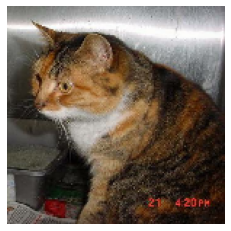

In [22]:
for images, labels in testing_dataset.take(1):
    image_cats_and_dogs = images[0]
    plt.imshow(image_cats_and_dogs.numpy().astype("uint8"))
    plt.axis("off")

1/1 [==============================] - 0s 107ms/step


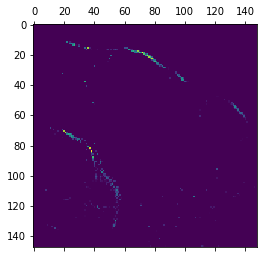

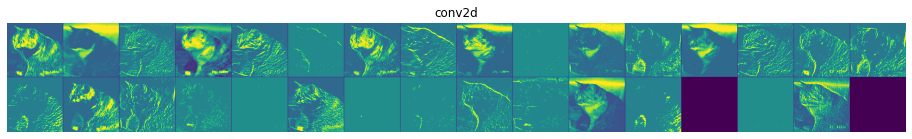

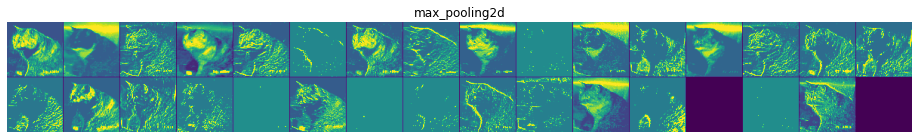

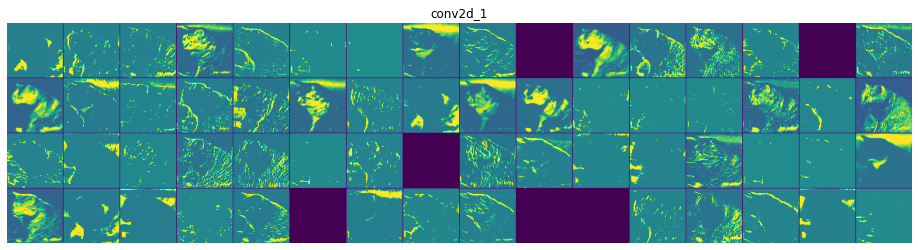

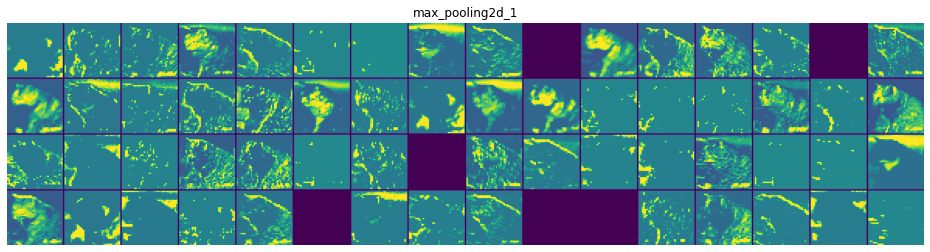

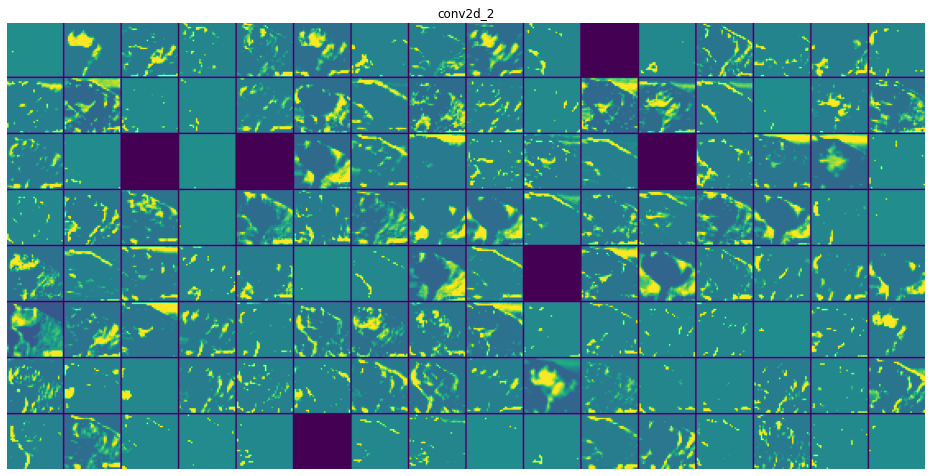

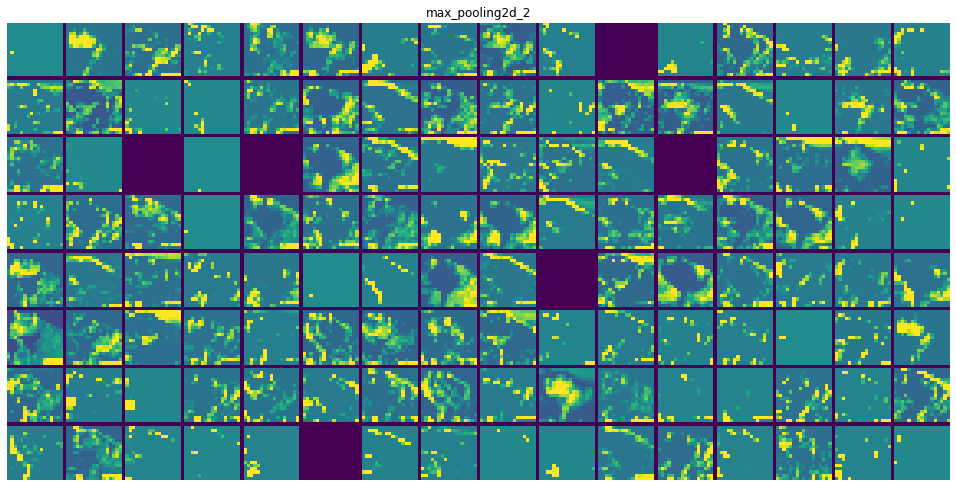

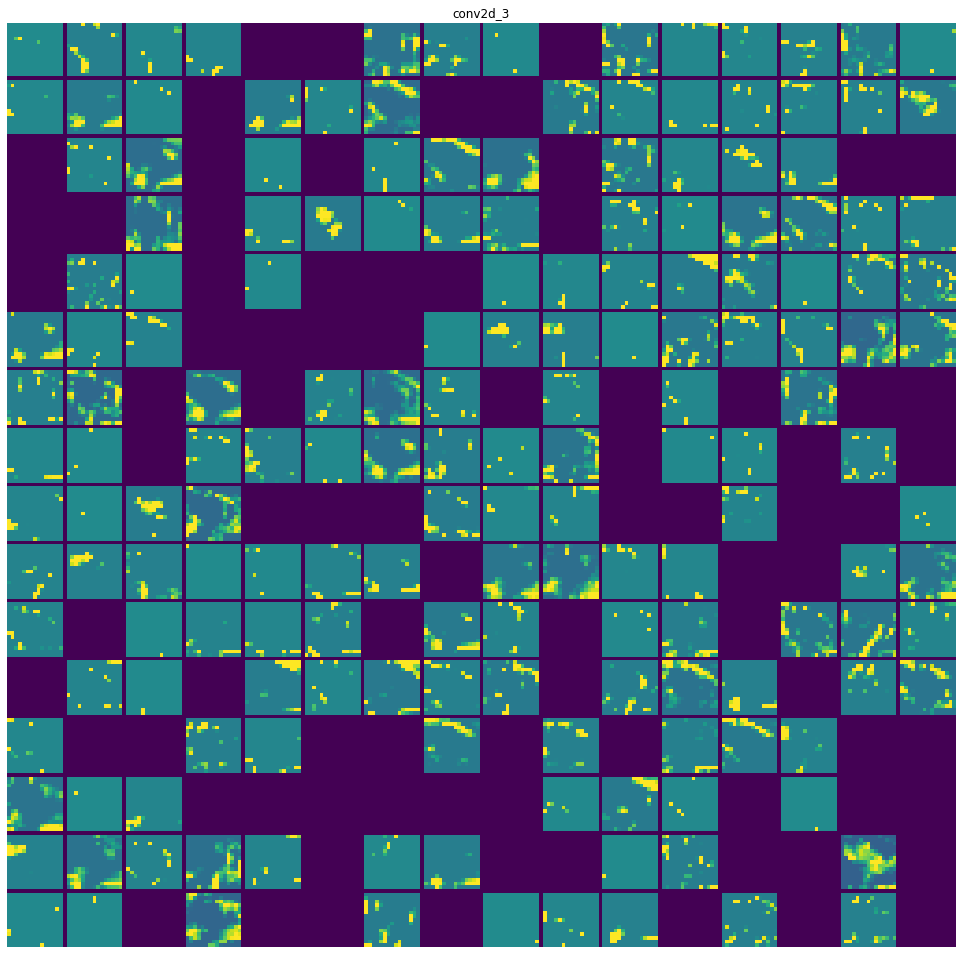

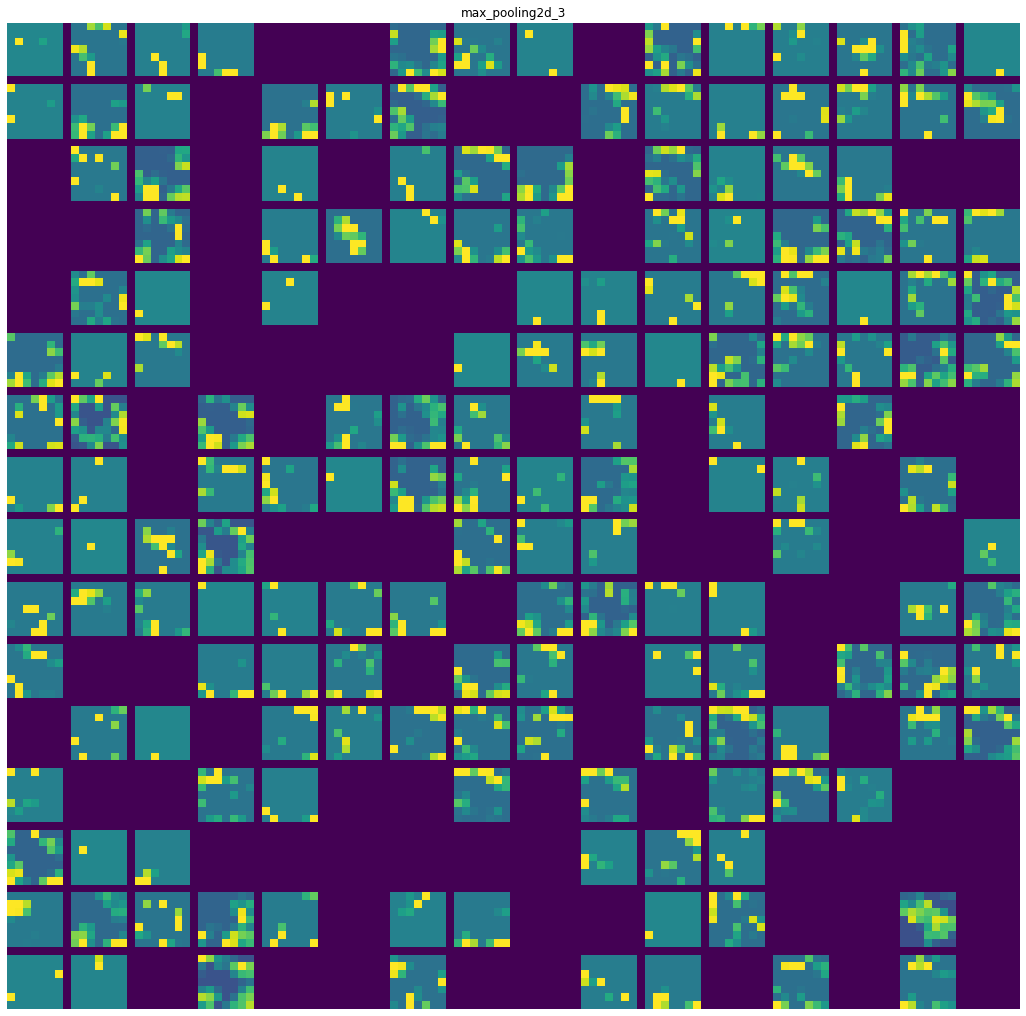

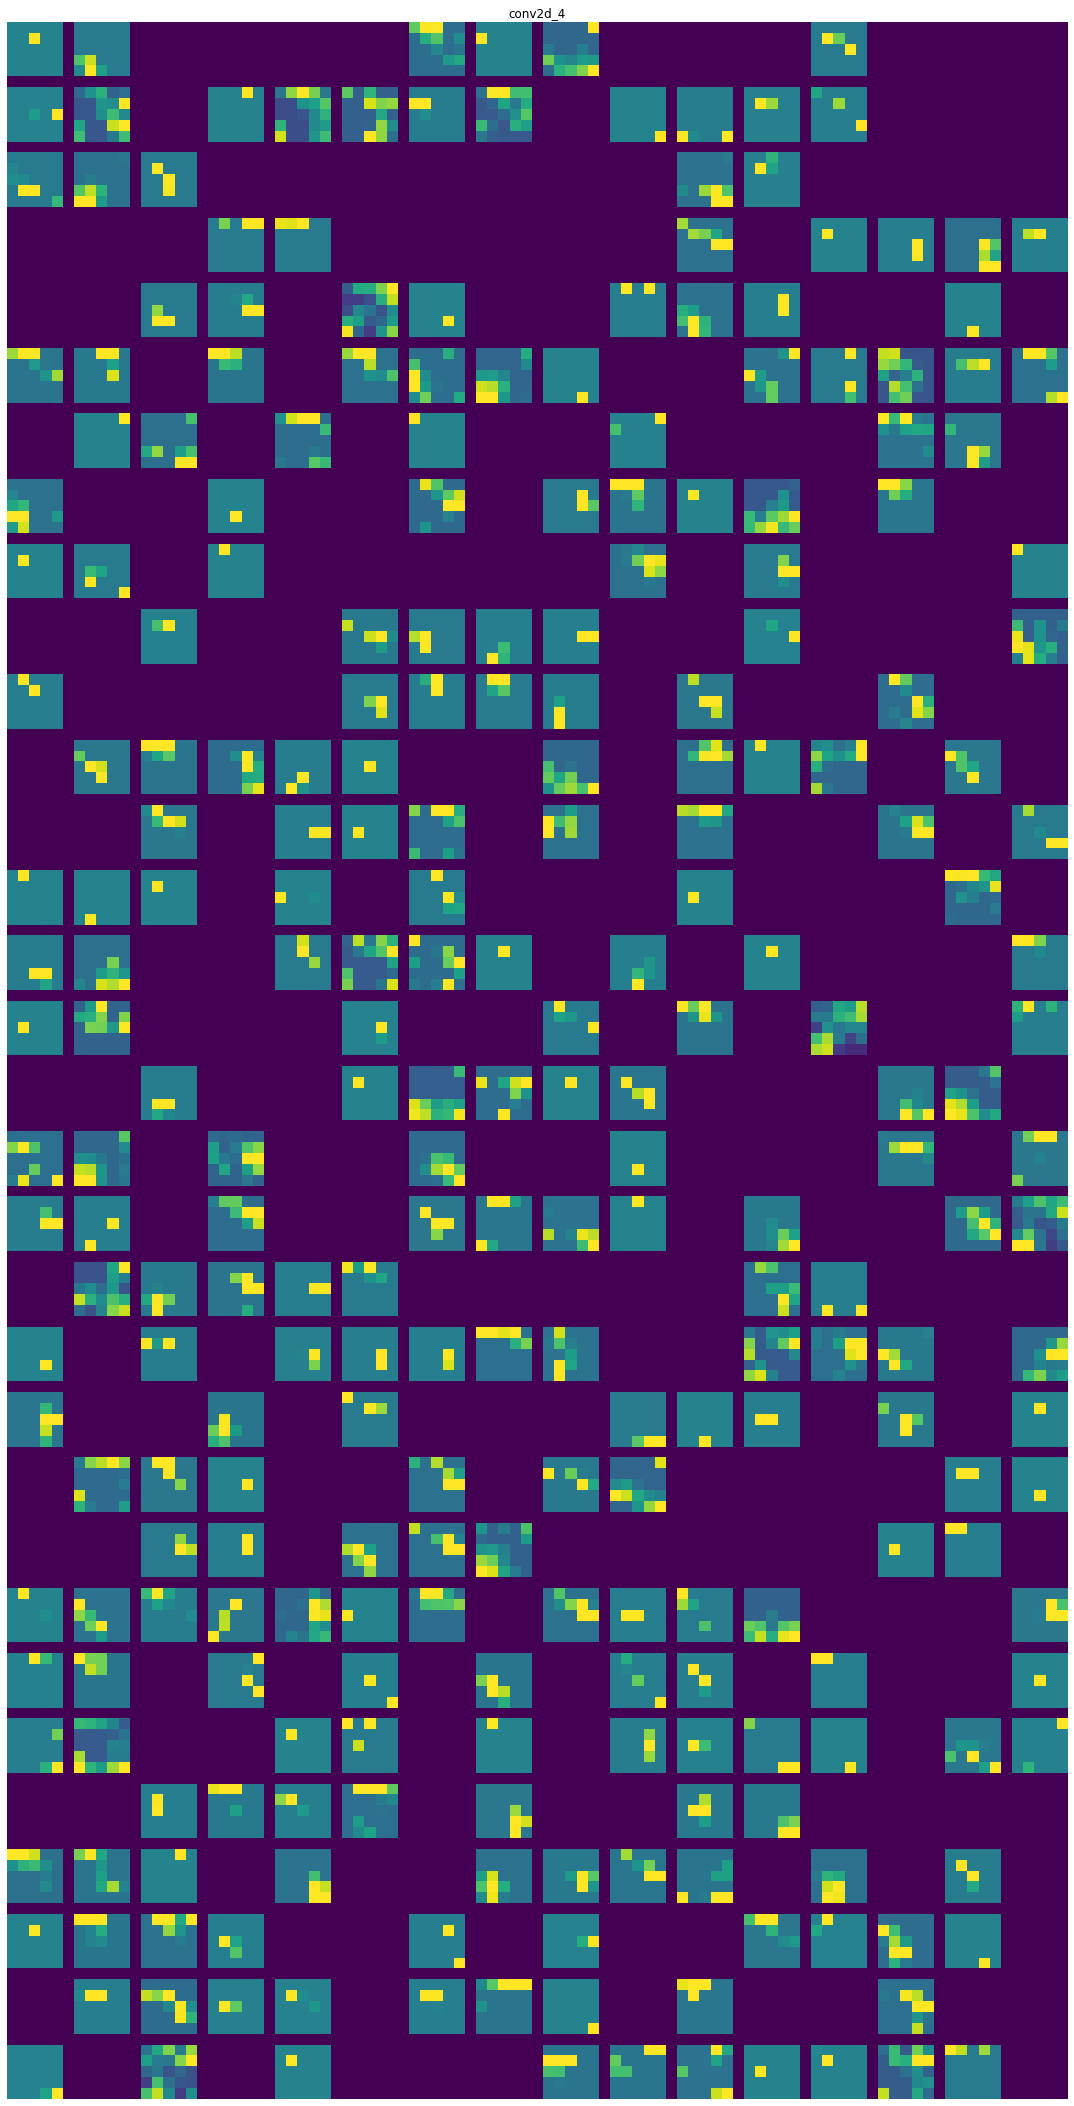

In [23]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
image_cats_and_dogs_reshaped = np.reshape(image_cats_and_dogs, [1, 150, 150, 3])
activations = activation_model.predict(image_cats_and_dogs_reshaped)

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row,
            ] = channel_image
    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

In [24]:
layer_name = "conv2d_1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
activation = feature_extractor(image_cats_and_dogs_reshaped)


def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [25]:
img_width = 150
img_height = 150


def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.0
    image = tf.random.uniform(
        minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3)
    )
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

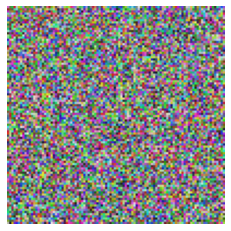

In [26]:
def process_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image


plt.axis("off")
plt.imshow(process_image(generate_filter_pattern(filter_index=2)))

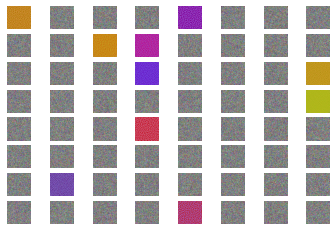

In [27]:
all_images = []
for filter_index in range(64):
    # print(f"Processing filter {filter_index}")
    image = process_image(generate_filter_pattern(filter_index))
    ax = plt.subplot(8, 8, filter_index + 1)
    plt.imshow(image)
    plt.axis("off")
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

In [28]:
last_conv_layer_name = "conv2d_4"
classifier_layer_names = [
    "flatten",
    "dense",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [29]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image_cats_and_dogs_reshaped)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

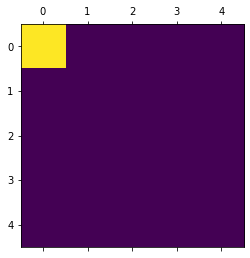

In [30]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

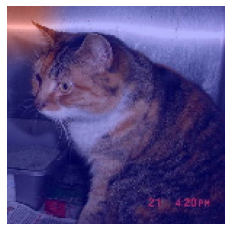

In [31]:
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize(
    (image_cats_and_dogs.shape[1], image_cats_and_dogs.shape[0])
)
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + image_cats_and_dogs
superimposed_img = array_to_img(superimposed_img)
plt.imshow(superimposed_img)
plt.axis("off")

save_path = "cats_dogs_cam.jpg"
superimposed_img.save(save_path)